<a href="https://colab.research.google.com/github/johntanas/it1244project/blob/main/code/model_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np

In [7]:
onlinedataset=True
if onlinedataset:
  url = "https://drive.google.com/file/d/1Ktdv2NTyK2AM48yBvbpFezd82-srqj7w/view?usp=sharing"
  url='https://drive.google.com/uc?id=' + url.split('/')[-2]
  cleaned_app_df=pd.read_csv(url,index_col=0)
  url = "https://drive.google.com/file/d/1QDhZ3u0BZX8uqMFkSWW-Ck59XvtEdxhy/view?usp=sharing"
  url='https://drive.google.com/uc?id=' + url.split('/')[-2]
  label_df=pd.read_csv(url,index_col=0)
else:
  pathtoapp="./content/cleaned_application.csv"
  cleaned_app_df=pd.read_csv(pathtoapp,index_col=0)
  pathtolabel="./content/credit_record.csv"
  label_df=pd.read_csv(pathtolabel,index_col=0)

In [8]:
dep_var="label"
random_state=42

In [9]:
train_df=label_df.merge(cleaned_app_df,how="inner")

In [10]:
def hamming_distance(x,y):
  labels=np.where(x>0.5,1,0)
  return sum(labels!=y)/len(labels)
def hamming_distance_accuracy(x, y): return 1-hamming_distance(x,y)

In [11]:
train_df["label"].describe()

count    36457.000000
mean         0.882300
std          0.322257
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: label, dtype: float64

Since the data is skewed to 1, we can have a baseline guess of setting all our labels to 1.

In [12]:
pred_baseline=np.repeat([1],36457)

In [13]:
hamming_distance_accuracy(pred_baseline, train_df["label"])

0.8822996955317223

Our models have to do better than this accuracy for it to be useful



In [14]:
cat_features = cleaned_app_df.columns[cleaned_app_df.dtypes == 'object'].to_list()

In [15]:
cleaned_app_df[cat_features].describe()

,gender,own_car,own_realty,income_type,education_level,family_status,house_type,job
count,438510,438510,438510,438510,438510,438510,438510,438510
unique,2,2,2,5,5,5,6,19
top,F,N,Y,Working,Secondary / secondary special,Married,House / apartment,Laborers
freq,294410,275431,304042,226079,301789,299798,393790,97953


We can use ordinal scaling for the factors ,even gender as there is only 2 genders and both the ordinal and nominal classification lead to 0 and 1 encoding so there is no difference. However, we have to create our own ranking for the factors with cardinality>2.

In [16]:
auto_cat_features=["gender","own_car","own_realty"]

In [17]:
for i in auto_cat_features:
    cat_features.remove(i)

In [18]:
cat_features

['income_type', 'education_level', 'family_status', 'house_type', 'job']

In [19]:
from sklearn.preprocessing import OrdinalEncoder

In [20]:
df1=cleaned_app_df.copy()

In [21]:
autoenc =OrdinalEncoder()
autoenc.fit(cleaned_app_df[auto_cat_features])
df1[auto_cat_features]=autoenc.transform(cleaned_app_df[auto_cat_features])

In [22]:
testenc =OrdinalEncoder()
testenc.fit(cleaned_app_df[cat_features])
testenc.categories_

[array(['Commercial associate', 'Pensioner', 'State servant', 'Student',
        'Working'], dtype=object),
 array(['Academic degree', 'Higher education', 'Incomplete higher',
        'Lower secondary', 'Secondary / secondary special'], dtype=object),
 array(['Civil marriage', 'Married', 'Separated', 'Single / not married',
        'Widow'], dtype=object),
 array(['Co-op apartment', 'House / apartment', 'Municipal apartment',
        'Office apartment', 'Rented apartment', 'With parents'],
       dtype=object),
 array(['Accountants', 'Cleaning staff', 'Cooking staff', 'Core staff',
        'Drivers', 'HR staff', 'High skill tech staff', 'IT staff',
        'Laborers', 'Low-skill Laborers', 'Managers', 'Medicine staff',
        'Pensioner', 'Private service staff', 'Realty agents',
        'Sales staff', 'Secretaries', 'Security staff',
        'Waiters/barmen staff'], dtype=object)]

In [23]:
categories=[['Student', 'Pensioner','Working','State servant','Commercial associate'],
     ['Lower secondary', 'Secondary / secondary special','Incomplete higher', 'Higher education', 'Academic degree'],
            ['Widow','Single / not married','Separated','Civil marriage', 'Married'],
            ['Rented apartment','With parents','Co-op apartment', 'Municipal apartment','Office apartment', 'House / apartment']]

Lets use median income level to justify the ordering of jobs instead of a biased personal heuristic!

In [24]:
job_income=dict(cleaned_app_df.groupby("job").apply(lambda x: x["income"].median()))

In [25]:
sorted_job_income={k: v for k, v in sorted(job_income.items(), key=lambda item: item[1])}

In [26]:
job_ranking=list(sorted_job_income.keys())

In [27]:
categories.append(job_ranking)

In [28]:
catenc =OrdinalEncoder(categories=categories)
catenc.fit(cleaned_app_df[cat_features])
df1[cat_features]=catenc.transform(cleaned_app_df[cat_features])

We can normalise birthday,employment length,num_child and standarise income and CNT_FAM_MEMBERS 

In [29]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [30]:
num_features = cleaned_app_df.columns[cleaned_app_df.dtypes != 'object'].to_list()
num_features.remove('id')

In [31]:
cleaned_app_df[num_features]

,num_child,income,birth_day,employment_length,work_phone,phone,email,CNT_FAM_MEMBERS
0,0,427500.0,-12005,-4542,1,0,0,2.0
1,0,427500.0,-12005,-4542,1,0,0,2.0
2,0,112500.0,-21474,-1134,0,0,0,2.0
3,0,270000.0,-19110,-3051,0,1,1,1.0
4,0,270000.0,-19110,-3051,0,1,1,1.0
...,...,...,...,...,...,...,...,...
423317,0,90000.0,-13432,-5446,0,0,0,1.0
426434,2,135000.0,-12576,-4382,0,0,0,4.0
432885,0,180000.0,-9970,-119,0,0,0,2.0
421225,1,180000.0,-10630,-454,0,0,0,3.0


In [32]:
std_feature=["income","CNT_FAM_MEMBERS"]

In [33]:
for i in std_feature:
    num_features.remove(i)
norm_features=std_feature.copy()

In [34]:
norm=MinMaxScaler()
norm.fit(cleaned_app_df[norm_features])
df1[norm_features]=norm.transform(cleaned_app_df[norm_features])

In [35]:
std=StandardScaler()
std.fit(cleaned_app_df[std_feature])
df1[std_feature]=std.transform(cleaned_app_df[std_feature])

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import  KFold, cross_val_score
from sklearn.metrics import roc_auc_score

In [37]:
def kf_cross_val(model, X, y): 
    scores = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for fold, (train_index, test_index) in enumerate(kf.split(X, y)):
        x_train = X.iloc[train_index]
        y_train = y.loc[train_index]
        x_test = X.loc[test_index]
        y_test = y.loc[test_index]
        model.fit(x_train,y_train)
        y_pred = model.predict_proba(x_test)[:,1]     
        scores.append(roc_auc_score(y_test,y_pred))       
    return scores

In [38]:
training_df=label_df.merge(df1,how="inner").drop("id",axis=1)

In [39]:
X_train=training_df[training_df.columns.difference(['label'])]
y_train=training_df["label"].copy()

In [40]:
lr = LogisticRegression(max_iter=2000, random_state=random_state)
lr_score = kf_cross_val(lr, X_train, y_train)
print(f"L2 Regularization: {round(np.mean(lr_score),5)} ({round(np.std(lr_score),5)})")

lr = LogisticRegression(max_iter=2000, penalty='none', random_state=random_state)
lr_score = kf_cross_val(lr, X_train, y_train)
print(f"No Regularization: {round(np.mean(lr_score),5)} ({round(np.std(lr_score),5)})")

L2 Regularization: 0.51966 (0.00326)
No Regularization: 0.51965 (0.00326)


It seems logistic Regression is no better than guessing due to the ordinal features in the dataset

Using Synthetic Minority Over-Sampling Technique(SMOTE) to overcome sample imbalance problem.

In [41]:
from imblearn.over_sampling import SMOTE

In [42]:
X=training_df[training_df.columns.difference(["label"])]
Y=training_df["label"]

In [43]:
Y = Y.astype('int')
X_balance,Y_balance = SMOTE().fit_resample(X,Y)
X_balance = pd.DataFrame(X_balance, columns = X.columns)

In [44]:
lr = LogisticRegression(max_iter=2000, random_state=random_state)
lr_score = kf_cross_val(lr,X_balance, Y_balance)
print(f"L2 Regularization: {round(np.mean(lr_score),5)} ({round(np.std(lr_score),5)})")

lr = LogisticRegression(max_iter=2000, penalty='none', random_state=random_state)
lr_score = kf_cross_val(lr, X_balance, Y_balance)
print(f"No Regularization: {round(np.mean(lr_score),5)} ({round(np.std(lr_score),5)})")

L2 Regularization: 0.55488 (0.045)
No Regularization: 0.55488 (0.045)


Does a bit better!

In [45]:
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from sklearn.model_selection import ShuffleSplit
from fastai.tabular.all import *
from sklearn.model_selection import KFold

In [46]:
df_nn=label_df.merge(cleaned_app_df,how="inner")

In [47]:
df_nn_final=df_nn.drop("id",axis=1)

In [48]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=1000, dep_var=dep_var)

In [49]:
sss = ShuffleSplit(n_splits=1, test_size=0.2)
train_idx, valid_idx = next(sss.split(train_df))
splits = (list(train_idx),list(valid_idx))

In [50]:
procs_nn = [Categorify, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [51]:
dls = to_nn.dataloaders(1024)

In [52]:
df_nn_final[cat_nn].nunique()

gender              2
own_car             2
own_realty          2
num_child           9
income_type         5
education_level     5
family_status       5
house_type          6
work_phone          2
phone               2
email               2
job                19
dtype: int64

In [53]:
y = to_nn.train.y

In [54]:
learn = tabular_learner(dls, layers=[500,250],loss_func=BCEWithLogitsLossFlat(),metrics=[accuracy,F1Score(),HammingLoss()])

SuggestedLRs(valley=0.0010000000474974513)

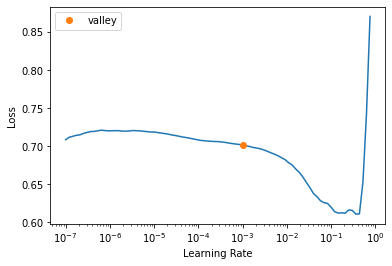

In [55]:
learn.lr_find()

In [56]:
learn.fit_one_cycle(5, 2e-2)  

epoch,train_loss,valid_loss,accuracy,f1_score,hamming_loss,time
0,0.562253,0.357402,0.114920,0.000000,0.885080,00:01
1,0.441939,0.357537,0.114920,0.000000,0.885080,00:01
2,0.398355,0.351245,0.114920,0.000000,0.885080,00:01
3,0.373924,0.346309,0.114920,0.000000,0.885080,00:02
4,0.358695,0.346785,0.114920,0.000000,0.885080,00:01


It seems that our model does better than a naive guess at statistically insiginificant level

It might be due to poor train test spliting. Lets try Kfolds

In [57]:
kf=KFold(n_splits=5, shuffle=True, random_state=random_state)

In [58]:
fold=1
for train_index, test_index in kf.split(df_nn_final):
  s=(list(train_index), list(test_index))
  to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=s, y_names=dep_var)
  dls = to_nn.dataloaders(1024)
  y = to_nn.train.y
  learn = tabular_learner(dls, layers=[500,250],loss_func=BCEWithLogitsLossFlat())
  learn.fit_one_cycle(5, 1e-2)  
  preds,targs = learn.get_preds()
  print(f"Accuracy of fold {fold}\n")
  print(hamming_distance_accuracy(preds, np.array(targs)).item())
  fold+=1

epoch,train_loss,valid_loss,time
0,0.621177,0.420504,00:01
1,0.462502,0.369883,00:01
2,0.407654,0.361498,00:01
3,0.379240,0.355414,00:01
4,0.361253,0.353858,00:01


Accuracy of fold 1

0.8821996708721886


epoch,train_loss,valid_loss,time
0,0.604006,0.410476,00:01
1,0.458691,0.375348,00:01
2,0.406019,0.365688,00:01
3,0.379058,0.355795,00:01
4,0.361902,0.353431,00:01


Accuracy of fold 2

0.8830224904004389


epoch,train_loss,valid_loss,time
0,0.604936,0.407361,00:01
1,0.461447,0.372035,00:01
2,0.407372,0.371289,00:01
3,0.379053,0.362310,00:01
4,0.361835,0.360958,00:01


Accuracy of fold 3

0.8799890275682348


epoch,train_loss,valid_loss,time
0,0.614374,0.398603,00:01
1,0.464697,0.355643,00:01
2,0.408760,0.353266,00:01
3,0.379936,0.354399,00:01
4,0.362824,0.350221,00:01


Accuracy of fold 4

0.8834179124948567


epoch,train_loss,valid_loss,time
0,0.606171,0.456767,00:01
1,0.461065,0.360989,00:01
2,0.407090,0.357531,00:01
3,0.379707,0.354701,00:01
4,0.362406,0.354440,00:01


Accuracy of fold 5

0.8836922232889864


In [59]:
class_0 = df_nn_final[df_nn_final['label'] == 0]
class_1 = df_nn_final[df_nn_final['label'] == 1]

In [60]:
class_count_0=len(class_0)

total class of 1 and 0: 1    4291
0    4291
Name: label, dtype: int64


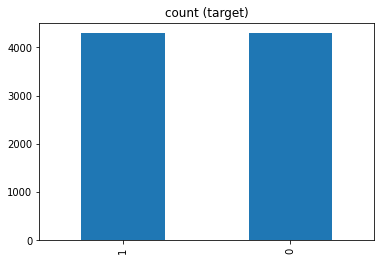

In [61]:
class_1_under = class_1.sample(class_count_0)

test_under = pd.concat([class_1_under, class_0], axis=0)

print("total class of 1 and 0:",test_under['label'].value_counts())# plot the count after under-sampeling
test_under['label'].value_counts().plot(kind='bar', title='count (target)')

In [62]:
sss = ShuffleSplit(n_splits=1, test_size=0.2)
train_idx, valid_idx = next(sss.split(test_under))
splits = (list(train_idx),list(valid_idx))

SuggestedLRs(valley=0.0003981071640737355)

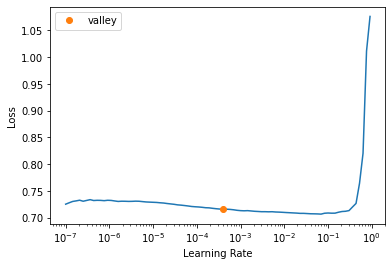

In [65]:
to_nn = TabularPandas(test_under, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)
dls = to_nn.dataloaders(1024)
learn = tabular_learner(dls, layers=[500,250],loss_func=BCEWithLogitsLossFlat(),metrics=[accuracy,F1Score(),HammingLoss()])
learn.lr_find()

In [66]:
learn.fit_one_cycle(5, 0.0005)  

epoch,train_loss,valid_loss,accuracy,f1_score,hamming_loss,time
0,0.716384,0.692267,0.503786,0.000000,0.496214,00:00
1,0.707797,0.692388,0.503786,0.000000,0.496214,00:00
2,0.701918,0.691184,0.503786,0.000000,0.496214,00:00
3,0.697949,0.691728,0.503786,0.000000,0.496214,00:00
4,0.694101,0.690860,0.503786,0.000000,0.496214,00:00


the model is learning nothing! no data correlation with labels!